# Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3
import collections

from daftpy.daftprep import (get_db, num_perc, process_price, process_coordinates, drop_coord_outliers, 
                             drop_floor_area, floor_area_wragling, process_floor_area, 
                             drop_info, process_info, process_views, process_rooms)

from daftpy.daftfeanalysis import missing_values

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Load Data

We load the information through a fuction which drops the advertiser's personal information. 

In [3]:
sale = get_db(dbname='2021-11-25.db')

In [4]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   daft_id                       15391 non-null  object
 1   item_id                       15391 non-null  object
 2   url                           15391 non-null  object
 3   name                          15113 non-null  object
 4   price                         15113 non-null  object
 5   info                          15113 non-null  object
 6   sale_type                     15106 non-null  object
 7   floor_area                    15106 non-null  object
 8   psr                           15311 non-null  object
 9   ber                           11649 non-null  object
 10  entered_renewed               15391 non-null  object
 11  views                         15391 non-null  object
 12  type_house                    11269 non-null  object
 13  energy_performan

# Check Missing Values and Duplicates

In [5]:
# Check missing values in absolute and relative terms
missing_values(sale)

,Absolute,Relative
daft_id,0,0.000000
item_id,0,0.000000
url,0,0.000000
name,278,0.018063
price,278,0.018063
info,278,0.018063
sale_type,285,0.018517
floor_area,285,0.018517
psr,80,0.005198
ber,3742,0.243129


The feature `energy_performance_indicator` has too many missing values, thus we should beware of them.

|Feature|% missing values|
|:---:|:---:|
|energy_performance_indicator|63|

As it has such a high percentage of missing values and it doesn't appear to be a critical feature we can drop it.

We shouldn't have any duplicated listing thanks to the *DuplicatesPipeline* implemented in the Scrapy project.

In [6]:
sale.duplicated(keep=False).sum()

0

In [7]:
sale.sample()

,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,energy_performance_indicator,coordinates,type,scraping_date,description
4698,16691690,3592615,https://www.daft.ie/for-sale/bungalow-rathcono...,"Rathconor, Four Mile House, Co. Roscommon","€250,000","4 Bed,3 Bath,140 m²,Bungalow",For Sale by Private Treaty,140 m²,004420,C3,24/11/2021,"1,889",house,NaN,53.685099+-8.229881,buy,2021-11-25,Property Partners Earley present to market a 4...


Next, let's start the cleansing and wrangling tasks. We will need cleaned prices and other features if we want to analize them.

# Energy Performance Indicator

We start dropping `energy_performance_indicator` column as we concluded above.

In [8]:
print(f'Before dropping: {sale.shape}')
sale.drop(columns=['energy_performance_indicator'], inplace=True)
print(f'After dropping: {sale.shape}')

Before dropping: (15391, 18)
After dropping: (15391, 17)


# Price

We have strange data points in the column. Let's investigate the different structures we can see:

In [9]:
# sale['price'].value_counts()

In [10]:
# The following are the diferent data point extructures that we can see in 
# the `price` column
sale['price'][[0, 8, 13, 28, 1442, 12842]]

0                         €549,000
8                    AMV: €725,000
13                             NaN
28            Price on Application
1442     AMV: Price on Application
12842          £149,000 (€173,554)
Name: price, dtype: object

**1. Price on Application**

`Price on Application` is the most repeated value in the `price` column. It equates to a 7.63% of ads.

In [11]:
# Ads with `Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='Price on Application')

Ads with "Price on Application": 1174
Ads with "Price on Application": 7.63%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
12638,14329177,3169689,https://www.daft.ie/for-sale/site-ref-921-wate...,"Ref 921 - Waterfront Site, Kilnabrack Lower, G...",Price on Application,"0.98 ac,Site",For Sale by Private Treaty,0.98 ac,002897,NaN,12/11/2021,"4,541",NaN,52.07064497840432+-9.947377114217545,buy,2021-11-25,***SALE ARRANGED***SALE ARRANGED****SALE ARRAN...


We will drop this kind of ads because we can't find out their prices.

**2. AMV: Price on Application**

In [12]:
# Ads with `AMV: Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='AMV: Price on Application')

Ads with "AMV: Price on Application": 8
Ads with "AMV: Price on Application": 0.05%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
11133,15531906,3441506,https://www.daft.ie/for-sale/detached-house-as...,"Askinamoe, Ferns, Enniscorthy, Co. Wexford",AMV: Price on Application,"1 Bed,Detached",For Sale by Public Auction,ON-LINE,002020,SI_666,24/11/2021,"4,118",house,52.6068023705902+-6.518592035977434,buy,2021-11-25,Property Ref: P4986\r\n \r\nValuable C. 7.2 Ac...


We will drop this kind of ads because we can't find out their prices.

**3. AMV: €725,000**

This patron is repeated a lot of times in the column, we will have to apply wrangling tasks on them.

**4. NaN**

In [13]:
# Ads with missing values
num_perc(df=sale, 
         feature='price', 
         pattern=np.nan)

Ads with "nan": 278
Ads with "nan": 1.81%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
598,95483062,3436295,https://www.daft.ie/new-home-for-sale/thornbro...,NaN,NaN,NaN,NaN,NaN,001314,A2,19/11/2021,"13,760",NaN,53.19079340305086+-6.133077740132876,buy,2021-11-25,Dillon Marshall New Homes are proud to present...


Advertisements with missing values in the `price` column are "Development" ads, not "Houses" ads. Development ads have several houses in it and that is why they have missing values. Furthermore, the houses belonging to developments are already scraped so we should drop the development ads.

In [14]:
# You can check the above statement with the lines of code bellow

# sale[sale['price'].isna()] # Commented for sthetic reasons
sale.loc[sale['price'].isna(), 'url'].sample().values # url to check the ad

array(['https://www.daft.ie/new-home-for-sale/loughvella-ennis-co-clare/3474268'],
      dtype=object)

**5. £149,000 (€173,554)**

In [15]:
# Ads with '£' pattern
num_perc(df=sale, 
         feature='price', 
         pattern='£')

Ads with "£": 25
Ads with "£": 0.16%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
13382,13155815,2731545,https://www.daft.ie/for-sale/detached-house-sh...,"Shandragh, Knockans, Rathlin Island, Ballycast...","£79,950 (€93,125)","2 Bed,1 Bath,Detached",For Sale by Private Treaty,For Sale by Private Treaty,002978,NaN,10/11/2021,"7,396",house,55.29709858131622+-6.21913270636054,buy,2021-11-25,"For Sale by Rodgers & Browne Estate Agents, Ho..."


Ads with prices in pounds are usually from North Ireland, which belongs to United Kingdom so we will drop these ads.

In [16]:
# You can check the above statement with the lines of code bellow

# sale.dropna(subset=['price']).loc[
 #    sale.dropna(subset=['price'])['price'].str.contains('£')] # Commented for sthetic reasons

sale.dropna(subset=['price']).loc[
    sale.dropna(subset=['price'])['price'].str.contains('£'), 'url'
                                 ].sample().values # url to check the ad

array(['https://www.daft.ie/for-sale/detached-house-4-old-chapel-road-aughnacloy-co-tyrone/3610164'],
      dtype=object)

**-> Conclusion**

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|€549,000|||Wrangling|
|AMV: €725,000|||Wrangling|
|£149,000 (€173,554)|25|0.16%|Drop|
|Price on Application|1174|7.63%|Drop|
|AMV: Price on Application|8|0.05%|Drop|
|NaN|278|1.81%|Drop|

Let's compare the before and after of transformations.

In [17]:
pd.DataFrame({'before': sale['price'], 
              'after': process_price(sale)['price']}).head(10)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


,before,after
0,"€549,000",549000.0
1,"€220,000",220000.0
2,"€495,000",495000.0
3,"€350,000",350000.0
4,"€450,000",450000.0
5,"€365,000",365000.0
6,"€325,000",325000.0
7,"€550,000",550000.0
8,"AMV: €725,000",725000.0
9,"€325,000",325000.0


Let's do it!

In [18]:
sale = process_price(sale.copy()).reset_index(drop=True)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


# Coordinates

There are no missing values in the coordinates columns and the structure is the same in all data points. We will use the `process_coordinates` function to make one new column for `latitude` and another one for `longitude`. The function also drops the `coordinates` column once it has been processed.

In [19]:
# Same structure in all data points in the column
sale['coordinates'].sample()

7355    53.299712+-6.494623
Name: coordinates, dtype: object

As the structure is the same in all ads, we can split the `coordinates` column in `+` using vectorized operations and create new columns from that. 

In [20]:
sale = process_coordinates(sale)

Shape before process: (13906, 17)
Shape after process: (13906, 18)


We can use the new columns to make a scatter plot in order to check whether the points show a similar form to Ireland.

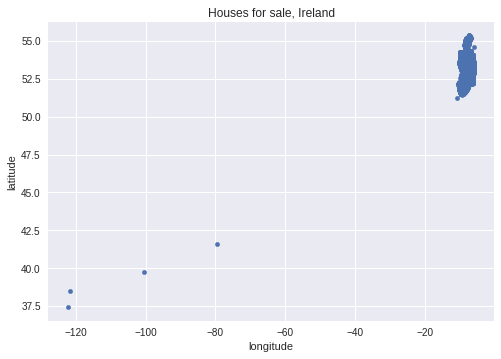

In [21]:
# Check coordinates outliers 
sale.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland');

As you can see above, there are some isolated points with a lower `latitude` that make it difficult to visualizate any country so the right thing would be drop them.

In [22]:
# Drops coordinates outliers
sale = drop_coord_outliers(sale)

Rows before dropping: 13906
Rows after dropping: 13899
----------
Difference: -7


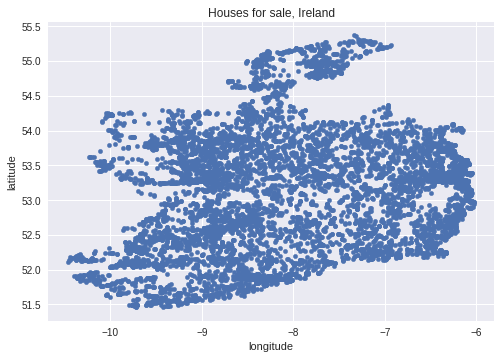

In [23]:
sale.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland'); # esta un poco achatada pero es Irlanda

# Floor Area

The most common pattern in the `floor_area` column follows a structure like this: `177 m²`. Nevertheless, there are several patterns which will need be handled.

In [24]:
# sale['floor_area'].sample(30)

In [25]:
# The following are the diferent data point extructures that we can see in 
# the `price` column
sale['floor_area'][[1861, 12076, 10284, 5114]]

1861     For Sale by Public Auction
12076                       0.65 ac
10284    For Sale by Private Treaty
5114                         267 m²
Name: floor_area, dtype: object

**1. m²**

`floor_area` is a promising predictor but only a 55% of ads show this information. We will drop the other values but let's explore ads whose `floor_area` feature is mesured in `acres` to check whether we can keep them.

In [26]:
# Ads with 'm²' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern='m²')

Ads with "m²": 7757
Ads with "m²": 55.81%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
2550,16892153,3610386,https://www.daft.ie/for-sale/end-of-terrace-ho...,"22 Ballentree Grove, Tyrellstown, Tyrrelstown,...",265000.0,"3 Bed,2 Bath,85 m²,End of Terrace",For Sale by Private Treaty,85 m²,003119,C2,15/11/2021,"1,821",house,buy,2021-11-25,Liam Reilly Auctioneers are proud to bring to ...,53.416673,-6.384818


**2. ac**

In [27]:
# Ads with 'ac' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern='ac')

Ads with "ac": 2540
Ads with "ac": 18.27%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
11151,14883019,3230278,https://www.daft.ie/for-sale/site-cooliska-coa...,"Cooliska, Coachford, Co. Cork",105000.0,"1.5 ac,Site",For Sale by Private Treaty,1.5 ac,001092,NaN,22/11/2021,"3,849",NaN,buy,2021-11-25,O'Mahony Walsh & Associates offer for sale c.1...,51.922217,-8.899655


If we check some ads we will see that ads with `ac` pattern refer to land extensions so we will drop them as well as the other ads with different patterns.

In [28]:
sale.dropna(subset=['floor_area']).loc[
    sale.dropna(subset=['floor_area'])['floor_area'].str.contains('ac'), 'url'
                                 ].sample().values # url to check the ad

array(['https://www.daft.ie/for-sale/site-lacken-kilkenny-road-castlecomer-co-kilkenny/1490866'],
      dtype=object)

**3. NaN**

There are just two missing values becuse we dropped almost all of them when we dropped the ads with `NaN` values in the `price` column.

In [29]:
# Ads with 'NaN' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern=np.nan)

Ads with "nan": 2
Ads with "nan": 0.01%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
8171,16148994,3531355,https://www.daft.ie/for-sale/terraced-house-st...,"St. Cormac's Park, Kilcormac, Co. Offaly",170000.0,"3 Bed,1 Bath,Terrace",NaN,NaN,003314,C2,25/11/2021,"4,151",house,buy,2021-11-25,Fabulous opportunity for first time buyers! St...,53.173276,-7.725095


**-> Conclusions**

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|756 m²|7757|55.81%|Wrangling|
|2 ac|2540|18.27%|Drop|
|NaN|2|0.01%|Drop|
|For Sale by Private Treaty|||Drop|
|Section 27|||Drop|
|Thu, Nov 25th at 12:00 PM|||Drop|

Let's compare the before and after of transformations.

In [30]:
pd.DataFrame({'before': sale.dropna(subset=['floor_area'])['floor_area'], 
              'after': process_floor_area(sale)['floor_area']}).head(10)

Rows after dropping: 13899
Rows after dropping: 7757
----------
Difference: -6142


,before,after
0,253 m²,253
1,For Sale by Private Treaty,NaN
2,165 m²,165
3,131 m²,131
4,188 m²,188
5,For Sale by Private Treaty,NaN
6,73 m²,73
7,111 m²,111
8,The Leinster Property Auctions,NaN
9,192 m²,192


The following function helps us dropping all rows that do not contain the pattern `m²` as well as those with missing values. Furthermore, it will wrang the column to let us analyze the data in the next notebook.

In [31]:
sale = process_floor_area(sale)

Rows after dropping: 13899
Rows after dropping: 7757
----------
Difference: -6142


# Info

If we look at the info example we can see four variables into the same column, so it would be a good idea to split them in different columns.

In [32]:
sale[['info', 'floor_area']].sample(5)

,info,floor_area
8090,"3 Bed,2 Bath,100 m²,Semi-D",100
9462,"3 Bed,3 Bath,98 m²,Semi-D",98
4777,"4 Bed,3 Bath,148 m²,Semi-D",148
602,"3 Bed,2 Bath,228 m²,Terrace",228
822,"4 Bed,2 Bath,164 m²,Detached",164


Also, we can see that there is no more missing values in the `info` column.

In [33]:
sale['info'].isna().sum()

0

Let's check the possible data point's length after been splitted by a comma:

In [34]:
# Create a DataFrame with the number of values with different lengths
pd.DataFrame({'Absolute': sale['info'].str.split(',').apply(len).value_counts(), 
              'Relative': sale['info'].str.split(',').apply(len).value_counts() / sale.shape[0]})

,Absolute,Relative
4,7662,0.987753
3,81,0.010442
2,14,0.001805


Let's dig a little deeper into the different cases.

**1. Length = 2**

Ads with splitted `info` length equal to two usually forget both the number of bedrooms and bathrooms.

In [35]:
# Splitted `info` length = 2
#sale.dropna(subset=['info']).loc[sale['info'].dropna().str.split(',').apply(len) == 2, ['info', 'floor_area']].sample(5) 
sale.loc[sale['info'].str.split(',').apply(len) == 2, ['info', 'floor_area']].sample(5) 

,info,floor_area
2290,"41 m²,Studio",41
10826,"2900 m²,Detached",2900
10998,"30 m²,Studio",30
6924,"3035 m²,Detached",3035
95,"99 m²,Terrace",99


**2. Length = 3**

If we check the rows which have a splitted `info` length of three we will see the following pattern where the advertiser forgot to add the number of bathrooms or the number of bedrooms. Usually he forgot the number of bathrooms.

In [36]:
sale.loc[(sale['info'].str.split(',').apply(len) == 3), ['info', 'floor_area']].head()

,info,floor_area
265,"3 Bed,90 m²,Semi-D",90
383,"2 Bed,79 m²,Apartment",79
984,"2 Bed,64 m²,Terrace",64
987,"4 Bed,173 m²,Terrace",173
1390,"6 Bed,190 m²,End of Terrace",190


**-> Conclusions**

Since rows that forget one or two values are so few we can drop them instead filling the lack of information.  

We will split the other ones into three columns as we already have the floor area.

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|4|7662|0.98|Wrangling: Split into 3 columns|
|3|81|0.01|Drop|
|2|14|0.001|Drop|

So let's do it! We will use a fuction to drop those rows which have a splitted `info` length less than four and we will split the other ones into three new columns as well as dropping the `info` column.

In [37]:
sale = process_info(sale)

Shape before dropping: (7757, 18)
Shape after dropping: (7662, 18)
----------
Dropped: 95 rows

Shape before splitting: (7662, 18)
Shape after splitting: (7662, 20)
----------
Difference: 2 columns


# Views

In [38]:
sale[['views']].sample(3)

,views
11801,"9,464"
3613,"3,519"
6824,"5,114"


The only wrangling task we have to apply in the `views` column is to quit the comma. We have a simple function for that. 

In [39]:
sale = process_views(sale)

# Bedroom and Bathroom

The only wrangling task we need to apply on `bedroom` and `bathroom` columns is isolating the number and erasing the word.

In [40]:
sale[['bedroom']].sample(3)

,bedroom
4190,2 Bed
4917,4 Bed
4775,3 Bed


In [41]:
sale[['bathroom']].sample(3)

,bathroom
4617,1 Bath
3409,1 Bath
11128,4 Bath


We have a simple function prepared to do it.

In [42]:
sale = process_rooms(sale)

In [43]:
sale[['bedroom', 'bathroom']].sample(3)

,bedroom,bathroom
7620,4,4
1105,3,2
3786,3,1


# Ber and Type House

![](imgs/ber.png)

[Building Energy Rating Certificate, SEAI](https://www.seai.ie/home-energy/building-energy-rating-ber/)

[Buiding Energy Rating Guide](https://www.seai.ie/publications/Your-Guide-to-Building-Energy-Rating.pdf)

`ber` and `type_house` columns don't need wrangling tasks since we extracted them pretty well thanks to Scrapy.

However, both columns contain aroun a 25% of missing values each one. We will leave them as they are for now.

In [44]:
sale[['ber', 'type_house']].sample(3)

,ber,type_house
7255,B3,apartment
4645,C2,apartment
8475,E1,house


# PSR

The Register identifies licensed property service providers by name, number, licence type and location.

You can find more information about PSR Licence Number in the [Property Seervices Regulatory Authority website](http://www.psr.ie/en/PSRA/Pages/Register_Licensed_PSP).

In [45]:
sale[['psr']].sample(3)

,psr
4050,002183
12828,002823
13224,004259


# Description

This information won't be used for now but I will keep it.

In [46]:
sale['description'].sample().values

array(['Dwelling on 6.25 Acres\r\nSpectacular views to the rear of the property with potential to create beautiful family home.\r\n13km from the Town of Ardee\r\n\r\nThis two bed property extending to 81 square metres / 881 square feet contains; entrance hall, sitting room, living area, utility, kitchen, toilet, stairs, bedroom (1) & bedroom (2). \r\n\r\nThe land extending to 6.25 acres offers tremendous potential to extend the property into a beautiful family home subject to the necessary planning permission. Useful outbuildings with the property.\r\n\r\nServices \r\nWater by private well, sewerage by septic tank and heating for one radiator off solid fuel stove in living area.\r\n\r\nThe property is situated just 7km from the Village of Nobber and 13km from the Town of Ardee off the N52.\r\nDirections: From Navan travel the R162 and when you reach Nobber turn right onto the L3401 signposted Drumconrath. Continue for 4.6km and turn left (signpost for Halpin Aluminium), take the next r

# Other columns

### Daft_id, Item_id, url, Name

These four columns don't seem very useful in order to infer houses prices. However, we should keep some of them for several reasons. 

- `daft_id`: This is the ad identifier provided by the website.
- `item_id`: After know that the website provides an identifier I bilt one so now it is completely useless. This identifier was extracted from the ad's url.
- `url`: The url could be useful as an indentifier but I prefer to give that task to the `daft.ie` column. The url will be saved just in case we need to check some advertisements.
- `name`: It can't be used as an idetifier because is possible to have some of them repeated. We will keep it because it could provide some information, but a priori I don't think we will use it.

|Column|What to do?|
|:---:|:---:|
|daft_ie|Keep|
|item_ie|Drop|
|url|Keep|
|name|Keep|

In [47]:
sale.drop(columns='item_id', inplace=True)

### Sale Type

The `sale_type` column doesn't seem very interesting but we will keep it by the moment.

Also, there are a few ads with prices that seem to be from developments. We will consider those ads as a house.

In [48]:
sale['sale_type'].value_counts()

For Sale by Private Treaty                7561
1 units available in this development       22
For Sale by Public Auction                  17
2 units available in this development        9
6 units available in this development        8
4 units available in this development        7
5 units available in this development        7
10 units available in this development       7
3 units available in this development        5
8 units available in this development        3
For Sale by Private Tender                   3
7 units available in this development        2
16 units available in this development       2
For Sale by Public Tender                    2
20 units available in this development       1
26 units available in this development       1
12 units available in this development       1
9 units available in this development        1
13 units available in this development       1
88 m²                                        1
111 m²                                       1
Name: sale_ty

In [49]:
sale.loc[sale['sale_type']=='2 units available in this development', 'url'].values

array(['https://www.daft.ie/new-home-for-sale/semi-detached-house-4-bedroom-semi-detached-house-archers-wood-archers-wood-delgany-co-wicklow/2744543',
       'https://www.daft.ie/new-home-for-sale/semi-detached-house-3-bedroom-semi-detached-archers-wood-archers-wood-delgany-co-wicklow/2743326',
       'https://www.daft.ie/new-home-for-sale/terraced-house-3-bedroom-terrace-house-graydon-graydon-newcastle-co-dublin/2534537',
       'https://www.daft.ie/new-home-for-sale/terraced-house-type-b-dromdiah-park-dromdiah-park-killeagh-co-cork/3507932',
       'https://www.daft.ie/new-home-for-sale/semi-detached-house-house-type-bb-old-forge-road-old-forge-road-milehouse-road-enniscorthy-co-wexford/3509743',
       'https://www.daft.ie/new-home-for-sale/duplex-the-maple-breagagh-valley-breagagh-valley-kilkenny-co-kilkenny/3572097',
       'https://www.daft.ie/new-home-for-sale/apartment-2-bedroom-apartment-plus-study-donnybrook-gardens-donnybrook-gardens-dublin-4/2515108',
       'https://www.da

### Entered-Renewed

`entered_renewed` is the date that the ad was entered or renewed. It doesn't need wrangling task but we could convert it to a datetime type. We will do that later in another notebook.

In [50]:
sale[['entered_renewed']].sample(3)

,entered_renewed
5749,23/11/2021
9027,24/11/2021
6802,24/11/2021


### Type

This column shows whether the ad is for sale or for rent. There are houses and rooms for rent in the other table of the database.

In [51]:
sale['type'].value_counts()

buy    7662
Name: type, dtype: int64

### scraping_date

In [52]:
sale['scraping_date'].value_counts()

2021-11-25    7662
Name: scraping_date, dtype: int64

# Check Missing Values

In [53]:
# Check missing values in absolute and relative terms
missing_values(sale)

,Absolute,Relative
daft_id,0,0.000000
url,0,0.000000
name,0,0.000000
price,0,0.000000
sale_type,0,0.000000
floor_area,0,0.000000
psr,16,0.002088
ber,192,0.025059
entered_renewed,0,0.000000
views,0,0.000000


# Save Data

In [54]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7662 entries, 0 to 13881
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   daft_id          7662 non-null   object 
 1   url              7662 non-null   object 
 2   name             7662 non-null   object 
 3   price            7662 non-null   float64
 4   sale_type        7662 non-null   object 
 5   floor_area       7662 non-null   object 
 6   psr              7646 non-null   object 
 7   ber              7470 non-null   object 
 8   entered_renewed  7662 non-null   object 
 9   views            7662 non-null   float64
 10  type_house       7175 non-null   object 
 11  type             7662 non-null   object 
 12  scraping_date    7662 non-null   object 
 13  description      7661 non-null   object 
 14  latitude         7662 non-null   float64
 15  longitude        7662 non-null   float64
 16  bedroom          7662 non-null   object 
 17  bathroom     

In [55]:
sale.to_csv('data/sale_cleaned.csv', sep=',', index=False) 